# Exercise 8:
### -By Team 7, Sanjana & Mahi

# Search Algorithm : 8-Piece Puzzle 

---

This notebook covers basic search algorithms for **priority organization in a 8-Piece Puzzle**.       

You will see *uninformed search* algorithms like `breadth_first_search`,`depth_first_search`,`uniform_cost_search` ,`depth_limited_search` and `iterative_deepening_search` as well as *informed search* algorithms like `greedy_search` and `astar_search` in action. The setup is a 8-Piece Puzzle with the problem of organizing the injured on the basis of priority. This notebook shows how to map a 8-Piece Puzzle to a graph, and then apply the search algorithms on the graph to solve the problem.   

---
This is the exercise 8, done by Yalamanchili Sanjana & Mahi Pandey

In [1]:
#Essential libraries
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue
import time
import sys
from queue import PriorityQueue

# Helper Functions for the 8-piece puzzle

In [2]:
def printPuzzle(puzzle_state):
    ''' Display the puzzle state
        Input : 2D NumPy array representing the puzzle state
        Output : Simple print of the corresponding puzzle
    '''
    print()
    for row in puzzle_state:
        for num in row:
            if num == 0:
                print("0", end=" ")  # Empty space
            else:
                print(num, end=" ")
        print()

def showPuzzle(puzzle_state):
    ''' Display the puzzle state
        Input : 2D NumPy array representing the puzzle state
        Output : Heatmap grid of the corresponding puzzle
    '''
    puzzle_state = np.array(puzzle_state)
    puzzle_state = puzzle_state * 255  # Adjusting values for visualization
    
    height, width = puzzle_state.shape
    f = plt.figure(figsize=(width, height))
    heatmap(puzzle_state, vmin=0, vmax=255, cmap="Greys", cbar=False)

def showPuzzleProblem(puzzle_state, initial_state, goal_state):
    ''' Display the puzzle state
        Display "initial" and "goal" state on the puzzle 
        Input : 2D NumPy array representing the puzzle state
        Input : 2D NumPy array representing the initial state
        Input : 2D NumPy array representing the goal state
        Output : Heatmap grid of the puzzle with markers
    '''
    puzzle_state = np.array(puzzle_state)
    puzzle_state = puzzle_state * 255  # Adjusting values for visualization
    
    height, width = puzzle_state.shape
    f = plt.figure(figsize=(width, height))
    
    # Display initial state
    for i in range(height):
        for j in range(width):
            if initial_state[i][j] != puzzle_state[i][j]:
                puzzle_state[i][j] = 128
                
    # Display goal state
    for i in range(height):
        for j in range(width):
            if goal_state[i][j] != puzzle_state[i][j]:
                puzzle_state[i][j] = 128
    
    heatmap(puzzle_state, vmin=0, vmax=255, cmap="Greys", cbar=False)
def showPuzzleProblem2(puzzle_state, initial_state, goal_state):
    ''' Display the puzzle state
        Display "initial" and "goal" state on the puzzle 
        Input : 2D NumPy array representing the puzzle state
        Input : 2D NumPy array representing the initial state
        Input : 2D NumPy array representing the goal state
        Output : ASCII art representation of the puzzle with markers
    '''
    print("Puzzle State:")
    print()
    height, width = puzzle_state.shape

    for i in range(height):
        for j in range(width):
            if initial_state[i][j] != puzzle_state[i][j]:
                print("{:2d}".format(puzzle_state[i][j]), end="|")  # Print puzzle state with markers
            elif goal_state[i][j] != puzzle_state[i][j]:
                print("{:2d}".format(puzzle_state[i][j]), end="|")  # Print puzzle state with markers
            elif puzzle_state[i][j] == 0:
                print("  ", end="|")  # Empty space represented by two spaces
            else:
                print("{:2d}".format(puzzle_state[i][j]), end="|")  # Print puzzle state without markers
        print("\n" + "-" * (width * 3 + 1))  # Horizontal line to separate rows
def showPuzzle2(puzzle_state):
    ''' Display the puzzle state
        Input : 2D NumPy array representing the puzzle state
        Output : ASCII art representation of the corresponding puzzle
    '''
    print()
    for row in puzzle_state:
        for num in row:
            if num == 0:
                print("  ", end="|")  # Empty space represented by two spaces
            else:
                print("{:2d}".format(num), end="|")  # Formatting to ensure alignment
        print("\n" + "-"*10)  # Horizontal line to separate rows

# Create the Puzzle as a 2D Grid

In [3]:
# Define the puzzle grid
# 0 represents the empty space
# This is just the sample puzzle grid 
# The numbers 1 to 8 represnt the injured people and the current placement of these numbers is for the creation of the puzzle
puzzle_grid = [[1, 2, 3],
               [4, 5, 6],
               [7, 8, 0]]  

# Convert to a NumPy array
puzzle_grid = np.array(puzzle_grid)

# Print the puzzle grid
print("8-Piece Puzzle Grid:")
printPuzzle(puzzle_grid)

8-Piece Puzzle Grid:

1 2 3 
4 5 6 
7 8 0 


In [4]:
#show the 8-Piece Puzzle using the helper function
showPuzzle2(puzzle_grid)


 1| 2| 3|
----------
 4| 5| 6|
----------
 7| 8|  |
----------


# Priority Organisation Problem in the 8-piece Puzzle

We are defining the priority organization problem by actually setting the **intial state** of the puzzle and the **goal state** of the puzzle that we want to achieve. 
We want to be able to reach the goal state of the puzzle using the search algorithms from the *current disorganised state* of the puzzle

In [5]:
puzzle_initial =[[4, 8, 5],
               [7, 2, 3],
               [1, 6, 0]]

puzzle_goal = [[1, 2, 3],
               [4, 5, 6],
               [7, 8, 0]]

showPuzzleProblem2(puzzle_grid,puzzle_initial,puzzle_goal)

Puzzle State:

 1| 2| 3|
----------
 4| 5| 6|
----------
 7| 8|  |
----------


## Extract Graph from the 8-Piece puzzle

In order to solve the priority organisation problem, we will first extract the traversal graph corresponding to the maze. To start with, let's define ⁠ PuzzleGraph ⁠.

In [6]:
class PuzzleGraph(object):
    ''' Class to represent a Graph
        Construction: Using Edges
    '''
    def __init__(self):
        self.edges = {}

    def all_edges(self):
        return self.edges

    def neighbors(self, state):
        return self.edges.get(state, [])

In [7]:
def puzzle_to_graph(puzzle_grid):
    ''' Converts an 8-piece puzzle to corresponding graph
        Input : 2D NumPy array representing the puzzle state
        Output : PuzzleGraph corresponding to input puzzle
    '''
    puzzleGraph = PuzzleGraph()  # Initialize a PuzzleGraph object
    (height, width) = puzzle_grid.shape
    
    for i in range(height):
        for j in range(width):
            if puzzle_grid[i, j] != 0:  # Skip the empty space
                neighbors = []

                # Check all possible moves for the current puzzle piece
                for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + di, j + dj
                    if 0 <= new_i < height and 0 <= new_j < width:
                        neighbors.append(((new_i, new_j), puzzle_grid[new_i, new_j]))

                # Insert edges in the graph
                if len(neighbors) > 0:
                    puzzleGraph.edges[(i, j)] = neighbors

    return puzzleGraph

In [8]:
puzzlegraph = puzzle_to_graph(puzzle_grid)

In [9]:
puzzlegraph.all_edges()

{(0, 0): [((0, 1), 2), ((1, 0), 4)],
 (0, 1): [((0, 2), 3), ((0, 0), 1), ((1, 1), 5)],
 (0, 2): [((0, 1), 2), ((1, 2), 6)],
 (1, 0): [((1, 1), 5), ((2, 0), 7), ((0, 0), 1)],
 (1, 1): [((1, 2), 6), ((1, 0), 4), ((2, 1), 8), ((0, 1), 2)],
 (1, 2): [((1, 1), 5), ((2, 2), 0), ((0, 2), 3)],
 (2, 0): [((2, 1), 8), ((1, 0), 4)],
 (2, 1): [((2, 2), 0), ((2, 0), 7), ((1, 1), 5)]}

In [10]:
def showPuzzleGraph(puzzleGraph):
    ''' Display a graph using networkx
        Input : PuzzleGraph from 8-piece puzzle
        Output : Input graph displayed
    '''
    edgeDict = puzzleGraph.all_edges()
    edgeList = []
    for node in edgeDict:
        for neighbor, weight in edgeDict[node]:
            edgeList.append((node, neighbor, {'weight': weight}))

    G = nx.Graph()
    G.add_edges_from(edgeList)

    f = plt.figure(figsize=(8, 8))  # Adjust figure size as needed
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')  # Adjust node size and color
    nx.draw_networkx_edges(G, pos, width=2, edge_color='black')  # Adjust edge width and color
    nx.draw_networkx_labels(G, pos, font_size=10)  # Adjust font size

    plt.axis("off")
    plt.show()


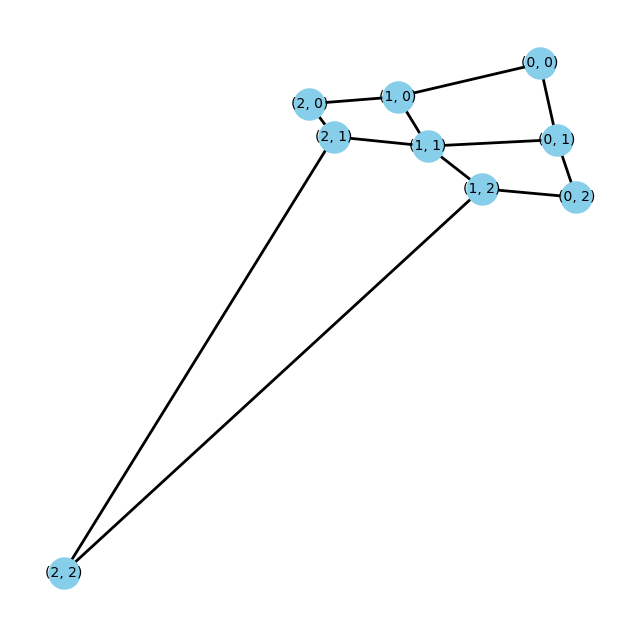

In [11]:
showPuzzleGraph(puzzlegraph)

# Implementing search algorithms

### Breadth-First-Search (BFS)

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [13]:
from collections import deque

class Node:
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action

class QueueFrontier:
    def __init__(self):
        self.frontier = deque()

    def add(self, node):
        self.frontier.append(node)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("Empty Frontier")
        else:
            return self.frontier.popleft()

class Puzzle:
    def __init__(self, start, startIndex, goal, goalIndex):
        self.start = [start, startIndex]
        self.goal = [goal, goalIndex]
        self.solution = None
        self.num_explored = 0
        self.search_depth = 0
        self.max_search_depth = 0
    
    def neighbors(self, state):
        mat, (row, col) = state
        results = [] 
        if row > 0:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row - 1][col]
            mat1[row - 1][col] = 0
            results.append(('up', [mat1, (row - 1, col)]))
        if col > 0:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row][col - 1]
            mat1[row][col - 1] = 0
            results.append(('left', [mat1, (row, col - 1)]))
        if row < 2:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row + 1][col]
            mat1[row + 1][col] = 0
            results.append(('down', [mat1, (row + 1, col)]))
        if col < 2:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row][col + 1]
            mat1[row][col + 1] = 0
            results.append(('right', [mat1, (row, col + 1)]))
        return results

    def print(self):
        solution = self.solution if self.solution is not None else None
        print("Start State:\n", self.start[0], "\n")
        print("Goal State:\n", self.goal[0], "\n")
        print("\nStates Explored: ", self.num_explored, "\n")
        print("Solution:\n ")
        for action, cell in zip(solution[0], solution[1]):
            print("action: ", action, "\n", cell[0], "\n")
            print("Goal Reached!!")

    def bfs_search(self):
        visited = set()
        start = Node(state=self.start, parent=None, action=None)
        frontier = QueueFrontier()
        frontier.add(start)
        while True:
            if frontier.empty():
                raise Exception("No solution")
            node = frontier.remove()
            self.num_explored += 1
            
            if (node.state[0] == self.goal[0]).all():
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                self.search_depth = len(actions)
                break
            set_of_tuples = tuple(tuple(row) for row in node.state[0])
            set_of_tuplesgoal = tuple(tuple(row) for row in self.goal[0])
            if set_of_tuples == set_of_tuplesgoal:
                break
            visited.add(set_of_tuples)
        
            for action, state in self.neighbors(node.state):
                set_of_tuplesstate = tuple(tuple(row) for row in state[0])
                if set_of_tuplesstate not in visited:
                    child = Node(state=state, parent=node, action=action)
                    set_of_tupleschild = tuple(tuple(row) for row in child.state[0])
                    visited.add(set_of_tupleschild)
                    frontier.add(child)

# Usage:
start = np.array([[4,8,5], [7,2,3], [1, 6, 0]])
goal = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
startIndex = (2, 2)
goalIndex = (2, 2)
p = Puzzle(start, startIndex, goal, goalIndex)
p.bfs_search()

# Printing the additional parameters
p.print()
print("Start State:\n", start, "\n")
print("Goal State:\n", goal, "\n")
print("Path to Goal:", p.solution[0])


Start State:
 [[4 8 5]
 [7 2 3]
 [1 6 0]] 

Goal State:
 [[1 2 3]
 [4 5 6]
 [7 8 0]] 


States Explored:  139530 

Solution:
 
action:  left 
 [[4 8 5]
 [7 2 3]
 [1 0 6]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [7 2 3]
 [0 1 6]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [0 2 3]
 [7 1 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 0 3]
 [7 1 6]] 

Goal Reached!!
action:  down 
 [[4 8 5]
 [2 1 3]
 [7 0 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 1 3]
 [7 6 0]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [2 1 0]
 [7 6 3]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [2 0 1]
 [7 6 3]] 

Goal Reached!!
action:  up 
 [[4 0 5]
 [2 8 1]
 [7 6 3]] 

Goal Reached!!
action:  right 
 [[4 5 0]
 [2 8 1]
 [7 6 3]] 

Goal Reached!!
action:  down 
 [[4 5 1]
 [2 8 0]
 [7 6 3]] 

Goal Reached!!
action:  down 
 [[4 5 1]
 [2 8 3]
 [7 6 0]] 

Goal Reached!!
action:  left 
 [[4 5 1]
 [2 8 3]
 [7 0 6]] 

Goal Reached!!
action:  up 
 [[4 5 1]
 [2 0 3]
 [7 8 6]] 

Goal Reached!!
action:  up 
 [[4 0 1]
 

### Depth-First-Search (DFS)

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [14]:

import numpy as np


class Node:
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action

class QueueFrontier:
    def __init__(self):
        self.frontier = []

    def add(self, node):
        self.frontier.append(node)

    def contains_state(self, state):
        return any((node.state[0] == state[0]).all() for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("Empty Frontier")
        else:
            node = self.frontier[0]
            self.frontier = self.frontier[1:]
        return node

class Puzzle:
    def __init__(self, start, startIndex, goal, goalIndex):
        self.start = [start, startIndex]
        self.goal = [goal, goalIndex]
        self.solution = None
        self.num_explored = 0
        self.search_depth = 0
        self.max_search_depth = 0
    
    def neighbors(self, state):
        mat, (row, col) = state
        results = [] 
        if row > 0:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row - 1][col]
            mat1[row - 1][col] = 0
            results.append(('up', [mat1, (row - 1, col)]))
        if col > 0:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row][col - 1]
            mat1[row][col - 1] = 0
            results.append(('left', [mat1, (row, col - 1)]))
        if row < 2:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row + 1][col]
            mat1[row + 1][col] = 0
            results.append(('down', [mat1, (row + 1, col)]))
        if col < 2:
            mat1 = np.copy(mat)
            mat1[row][col] = mat1[row][col + 1]
            mat1[row][col + 1] = 0
            results.append(('right', [mat1, (row, col + 1)]))
        return results

    def print(self):
        solution = self.solution if self.solution is not None else None
        print("Start State:\n", self.start[0], "\n")
        print("Goal State:\n", self.goal[0], "\n")
        print("\nStates Explored: ", self.num_explored, "\n")
        print("Solution:\n ")
        for action, cell in zip(solution[0], solution[1]):
            print("action: ", action, "\n", cell[0], "\n")
            print("Goal Reached!!")

    def dfs_search(self):
        start_time = time.time()
        visited = set()
        start = Node(state=self.start, parent=None, action=None)
        frontier = QueueFrontier()
        frontier.add(start)
        while True:
            if frontier.empty():
                raise Exception("No solution")
            node = frontier.remove()
            self.num_explored += 1
            
            if (node.state[0] == self.goal[0]).all():
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                self.search_depth = len(actions)
                break
            set_of_tuples = tuple(tuple(row) for row in node.state[0])
            set_of_tuplesgoal = tuple(tuple(row) for row in self.goal[0])
            if set_of_tuples == set_of_tuplesgoal:
                break
            visited.add(set_of_tuples)
        
            for action, state in self.neighbors(node.state):
                set_of_tuplesstate = tuple(tuple(row) for row in state[0])
                if set_of_tuplesstate not in visited:
                    child = Node(state=state, parent=node, action=action)
                    set_of_tupleschild = tuple(tuple(row) for row in child.state[0])
                    visited.add(set_of_tupleschild)
                    frontier.add(child)
                    self.max_search_depth = max(self.max_search_depth, len(frontier.frontier))

# Creating the puzzle and solving it
start = np.array([[4,8,5], [7,2,3], [1, 6, 0]])
goal = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
startIndex = (2, 2)
goalIndex = (2, 2)
p = Puzzle(start, startIndex, goal, goalIndex)
p.dfs_search()

# Printing the additional parameters
p.print()
print("Start State:\n", start, "\n")
print("Goal State:\n", goal, "\n")
print("Path to Goal:", p.solution[0])
print("Search Depth:", p.search_depth)
print("Max Search Depth:", p.max_search_depth)


Start State:
 [[4 8 5]
 [7 2 3]
 [1 6 0]] 

Goal State:
 [[1 2 3]
 [4 5 6]
 [7 8 0]] 


States Explored:  139530 

Solution:
 
action:  left 
 [[4 8 5]
 [7 2 3]
 [1 0 6]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [7 2 3]
 [0 1 6]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [0 2 3]
 [7 1 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 0 3]
 [7 1 6]] 

Goal Reached!!
action:  down 
 [[4 8 5]
 [2 1 3]
 [7 0 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 1 3]
 [7 6 0]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [2 1 0]
 [7 6 3]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [2 0 1]
 [7 6 3]] 

Goal Reached!!
action:  up 
 [[4 0 5]
 [2 8 1]
 [7 6 3]] 

Goal Reached!!
action:  right 
 [[4 5 0]
 [2 8 1]
 [7 6 3]] 

Goal Reached!!
action:  down 
 [[4 5 1]
 [2 8 0]
 [7 6 3]] 

Goal Reached!!
action:  down 
 [[4 5 1]
 [2 8 3]
 [7 6 0]] 

Goal Reached!!
action:  left 
 [[4 5 1]
 [2 8 3]
 [7 0 6]] 

Goal Reached!!
action:  up 
 [[4 5 1]
 [2 0 3]
 [7 8 6]] 

Goal Reached!!
action:  up 
 [[4 0 1]
 

### Depth-Limited-Search (DLS)

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [32]:
class Node:
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action

class Puzzle:

    def print(self):
        solution = self.solution if self.solution is not None else None
        print("Start State:\n", self.start[0], "\n")
        print("Goal State:\n", self.goal[0], "\n")
        print("\nStates Explored: ", self.num_explored, "\n")
        print("Solution:\n ")
        for action, cell in zip(solution[0], solution[1]):
            print("action: ", action, "\n", cell[0], "\n")
            print("Goal Reached!!")

    def __init__(self, start, startIndex, goal, goalIndex):
        self.start = [start, startIndex]
        self.goal = [goal, goalIndex]
        self.solution = None
        self.num_explored = 0
        self.search_depth = 0
        self.max_search_depth = 0
    
    def neighbors(self, state):
        mat, (row, col) = state
        results = []

        # Check all possible moves for the current puzzle state
        if row > 0:
            mat1 = mat.copy()
            mat1[row][col], mat1[row - 1][col] = mat1[row - 1][col], mat1[row][col]
            results.append(('up', [mat1, (row - 1, col)]))
        if col > 0:
            mat1 = mat.copy()
            mat1[row][col], mat1[row][col - 1] = mat1[row][col - 1], mat1[row][col]
            results.append(('left', [mat1, (row, col - 1)]))
        if row < 2:
            mat1 = mat.copy()
            mat1[row][col], mat1[row + 1][col] = mat1[row + 1][col], mat1[row][col]
            results.append(('down', [mat1, (row + 1, col)]))
        if col < 2:
            mat1 = mat.copy()
            mat1[row][col], mat1[row][col + 1] = mat1[row][col + 1], mat1[row][col]
            results.append(('right', [mat1, (row, col + 1)]))

        return results

    def depth_limited_search(self, limit):
        visited = set()
        start = Node(state=self.start, parent=None, action=None)
        frontier = [start]

        while frontier:
            node = frontier.pop()
            self.num_explored += 1

            if (node.state[0] == self.goal[0]).all():
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                self.search_depth = len(actions)
                return True

            # Check if the search depth exceeds the limit
            if self.search_depth < limit:
                set_of_tuples = tuple(tuple(row) for row in node.state[0])
                visited.add(set_of_tuples)
                
                for action, state in self.neighbors(node.state):
                    set_of_tuplesstate = tuple(tuple(row) for row in state[0])
                    if set_of_tuplesstate not in visited:
                        child = Node(state=state, parent=node, action=action)
                        frontier.append(child)
                        self.max_search_depth = max(self.max_search_depth, len(frontier))

        return False


# Creating the puzzle and solving it
start = np.array([[4,8,5], [7,2,3], [1, 6, 0]])
goal = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
startIndex = (2, 2)
goalIndex = (2, 2)
p = Puzzle(start, startIndex, goal, goalIndex)
limit = 10  # Depth limit
found = p.depth_limited_search(limit)

if found:
    p.print()
    print("Start State:\n", start, "\n")
    print("Goal State:\n", goal, "\n")
    print("Path to Goal:", p.solution[0])
    print("Search Depth:", p.search_depth)
    print("Max Search Depth:", p.max_search_depth)
else:
    print("No solution found within the depth limit.")


Start State:
 [[4 8 5]
 [7 2 3]
 [1 6 0]] 

Goal State:
 [[1 2 3]
 [4 5 6]
 [7 8 0]] 


States Explored:  77183 

Solution:
 
action:  left 
 [[4 8 5]
 [7 2 3]
 [1 0 6]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [7 2 3]
 [0 1 6]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [0 2 3]
 [7 1 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 0 3]
 [7 1 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 3 0]
 [7 1 6]] 

Goal Reached!!
action:  down 
 [[4 8 5]
 [2 3 6]
 [7 1 0]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [2 3 6]
 [7 0 1]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [2 3 6]
 [0 7 1]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [0 3 6]
 [2 7 1]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [3 0 6]
 [2 7 1]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [3 6 0]
 [2 7 1]] 

Goal Reached!!
action:  down 
 [[4 8 5]
 [3 6 1]
 [2 7 0]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [3 6 1]
 [2 0 7]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [3 6 1]
 [0 2 7]] 

Goal Reached!!
action:  up 
 [[4 8 

 [[3 7 6]
 [5 2 8]
 [4 1 0]] 

Goal Reached!!
action:  left 
 [[3 7 6]
 [5 2 8]
 [4 0 1]] 

Goal Reached!!
action:  left 
 [[3 7 6]
 [5 2 8]
 [0 4 1]] 

Goal Reached!!
action:  up 
 [[3 7 6]
 [0 2 8]
 [5 4 1]] 

Goal Reached!!
action:  right 
 [[3 7 6]
 [2 0 8]
 [5 4 1]] 

Goal Reached!!
action:  right 
 [[3 7 6]
 [2 8 0]
 [5 4 1]] 

Goal Reached!!
action:  down 
 [[3 7 6]
 [2 8 1]
 [5 4 0]] 

Goal Reached!!
action:  left 
 [[3 7 6]
 [2 8 1]
 [5 0 4]] 

Goal Reached!!
action:  left 
 [[3 7 6]
 [2 8 1]
 [0 5 4]] 

Goal Reached!!
action:  up 
 [[3 7 6]
 [0 8 1]
 [2 5 4]] 

Goal Reached!!
action:  right 
 [[3 7 6]
 [8 0 1]
 [2 5 4]] 

Goal Reached!!
action:  down 
 [[3 7 6]
 [8 5 1]
 [2 0 4]] 

Goal Reached!!
action:  right 
 [[3 7 6]
 [8 5 1]
 [2 4 0]] 

Goal Reached!!
action:  up 
 [[3 7 6]
 [8 5 0]
 [2 4 1]] 

Goal Reached!!
action:  left 
 [[3 7 6]
 [8 0 5]
 [2 4 1]] 

Goal Reached!!
action:  down 
 [[3 7 6]
 [8 4 5]
 [2 0 1]] 

Goal Reached!!
action:  right 
 [[3 7 6]
 [8 4 5]
 [2 1 

 [[1 5 6]
 [7 8 2]
 [3 0 4]] 

Goal Reached!!
action:  left 
 [[1 5 6]
 [7 8 2]
 [0 3 4]] 

Goal Reached!!
action:  up 
 [[1 5 6]
 [0 8 2]
 [7 3 4]] 

Goal Reached!!
action:  right 
 [[1 5 6]
 [8 0 2]
 [7 3 4]] 

Goal Reached!!
action:  right 
 [[1 5 6]
 [8 2 0]
 [7 3 4]] 

Goal Reached!!
action:  down 
 [[1 5 6]
 [8 2 4]
 [7 3 0]] 

Goal Reached!!
action:  left 
 [[1 5 6]
 [8 2 4]
 [7 0 3]] 

Goal Reached!!
action:  left 
 [[1 5 6]
 [8 2 4]
 [0 7 3]] 

Goal Reached!!
action:  up 
 [[1 5 6]
 [0 2 4]
 [8 7 3]] 

Goal Reached!!
action:  right 
 [[1 5 6]
 [2 0 4]
 [8 7 3]] 

Goal Reached!!
action:  right 
 [[1 5 6]
 [2 4 0]
 [8 7 3]] 

Goal Reached!!
action:  down 
 [[1 5 6]
 [2 4 3]
 [8 7 0]] 

Goal Reached!!
action:  left 
 [[1 5 6]
 [2 4 3]
 [8 0 7]] 

Goal Reached!!
action:  left 
 [[1 5 6]
 [2 4 3]
 [0 8 7]] 

Goal Reached!!
action:  up 
 [[1 5 6]
 [0 4 3]
 [2 8 7]] 

Goal Reached!!
action:  right 
 [[1 5 6]
 [4 0 3]
 [2 8 7]] 

Goal Reached!!
action:  right 
 [[1 5 6]
 [4 3 0]
 [2 8

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Uniform-cost-Search (UCS)

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [41]:
import heapq

class Puzzle:
    def __init__(self, start, startIndex, goal, goalIndex):
        self.start = [start, startIndex]
        self.goal = [goal, goalIndex]
        self.solution = None
        self.num_explored = 0
        self.search_depth = 0
        self.max_search_depth = 0

    def neighbors(self, state):
        mat, (row, col) = state
        results = []

        # Check all possible moves for the current puzzle state
        if row > 0:
            mat1 = mat.copy()
            mat1[row][col], mat1[row - 1][col] = mat1[row - 1][col], mat1[row][col]
            results.append(('up', [mat1, (row - 1, col)]))
        if col > 0:
            mat1 = mat.copy()
            mat1[row][col], mat1[row][col - 1] = mat1[row][col - 1], mat1[row][col]
            results.append(('left', [mat1, (row, col - 1)]))
        if row < 2:
            mat1 = mat.copy()
            mat1[row][col], mat1[row + 1][col] = mat1[row + 1][col], mat1[row][col]
            results.append(('down', [mat1, (row + 1, col)]))
        if col < 2:
            mat1 = mat.copy()
            mat1[row][col], mat1[row][col + 1] = mat1[row][col + 1], mat1[row][col]
            results.append(('right', [mat1, (row, col + 1)]))

        return results

    def uniform_cost_search(self):
        start = Node(state=self.start, parent=None, action=None, cost=0)
        frontier = [(0, start)]  # Priority queue with (cost, node) tuples
        visited = set()

        while frontier:
            cost, node = heapq.heappop(frontier)  # Get node with lowest cost
            self.num_explored += 1

            if (node.state[0] == self.goal[0]).all():
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                self.search_depth = len(actions)
                return True

            set_of_tuples = tuple(tuple(row) for row in node.state[0])
            if set_of_tuples not in visited:
                visited.add(set_of_tuples)
                for action, state in self.neighbors(node.state):
                    child_cost = node.cost + 1  # Assuming uniform cost
                    child = Node(state=state, parent=node, action=action, cost=child_cost)
                    heapq.heappush(frontier, (child_cost, child))  # Push (cost, node) tuple
                    self.max_search_depth = max(self.max_search_depth, len(frontier))

        return False
    
    def print_solution(self):
        if self.solution is not None:
            actions, cells = self.solution
            print("Solution:")
            for action, cell in zip(actions, cells):
                print("Action:", action)
                print("Cell:")
                print(cell[0])
                print()
            print("Start State:")
            print(self.start[0])
            print("Goal State:")
            print(self.goal[0])
            print("Path to Goal:", actions)
            print("Search Depth:", self.search_depth)
            print("Max Search Depth:", self.max_search_depth)
            print("Number of States Explored:", self.num_explored)  # Print number of states explored
        else:
            print("No solution found.")


class Node:
    def __init__(self, state, parent, action, cost):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
    
    def __lt__(self, other):
        return self.cost < other.cost


# Creating the puzzle and solving it
start = np.array([[4,8,5], [7,2,3], [1, 6, 0]])
goal = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
startIndex = (2, 2)
goalIndex = (2, 2)
p = Puzzle(start, startIndex, goal, goalIndex)
found = p.uniform_cost_search()

if found:
    p.print_solution()
else:
    print("No solution found within the depth limit.")


Solution:
Action: left
Cell:
[[4 8 5]
 [7 2 3]
 [1 0 6]]

Action: left
Cell:
[[4 8 5]
 [7 2 3]
 [0 1 6]]

Action: up
Cell:
[[4 8 5]
 [0 2 3]
 [7 1 6]]

Action: right
Cell:
[[4 8 5]
 [2 0 3]
 [7 1 6]]

Action: right
Cell:
[[4 8 5]
 [2 3 0]
 [7 1 6]]

Action: up
Cell:
[[4 8 0]
 [2 3 5]
 [7 1 6]]

Action: left
Cell:
[[4 0 8]
 [2 3 5]
 [7 1 6]]

Action: down
Cell:
[[4 3 8]
 [2 0 5]
 [7 1 6]]

Action: down
Cell:
[[4 3 8]
 [2 1 5]
 [7 0 6]]

Action: right
Cell:
[[4 3 8]
 [2 1 5]
 [7 6 0]]

Action: up
Cell:
[[4 3 8]
 [2 1 0]
 [7 6 5]]

Action: up
Cell:
[[4 3 0]
 [2 1 8]
 [7 6 5]]

Action: left
Cell:
[[4 0 3]
 [2 1 8]
 [7 6 5]]

Action: down
Cell:
[[4 1 3]
 [2 0 8]
 [7 6 5]]

Action: left
Cell:
[[4 1 3]
 [0 2 8]
 [7 6 5]]

Action: up
Cell:
[[0 1 3]
 [4 2 8]
 [7 6 5]]

Action: right
Cell:
[[1 0 3]
 [4 2 8]
 [7 6 5]]

Action: down
Cell:
[[1 2 3]
 [4 0 8]
 [7 6 5]]

Action: right
Cell:
[[1 2 3]
 [4 8 0]
 [7 6 5]]

Action: down
Cell:
[[1 2 3]
 [4 8 5]
 [7 6 0]]

Action: left
Cell:
[[1 2 3]
 [4 8 5

### Iterative-Deepening-Search (IDS)
*a combination of breadth first search and depth first search*

**Uninformed Search** : Focusses on the graph structure and not the *cost from start* or *distance from goal*.

In [33]:
class Puzzle:
    def __init__(self, start, startIndex, goal, goalIndex):
        self.start = [start, startIndex]
        self.goal = [goal, goalIndex]
        self.solution = None
        self.num_explored = 0
        self.search_depth = 0
        self.max_search_depth = 0

    def neighbors(self, state):
        mat, (row, col) = state
        results = []

        # Check all possible moves for the current puzzle state
        if row > 0:
            mat1 = mat.copy()
            mat1[row][col], mat1[row - 1][col] = mat1[row - 1][col], mat1[row][col]
            results.append(('up', [mat1, (row - 1, col)]))
        if col > 0:
            mat1 = mat.copy()
            mat1[row][col], mat1[row][col - 1] = mat1[row][col - 1], mat1[row][col]
            results.append(('left', [mat1, (row, col - 1)]))
        if row < 2:
            mat1 = mat.copy()
            mat1[row][col], mat1[row + 1][col] = mat1[row + 1][col], mat1[row][col]
            results.append(('down', [mat1, (row + 1, col)]))
        if col < 2:
            mat1 = mat.copy()
            mat1[row][col], mat1[row][col + 1] = mat1[row][col + 1], mat1[row][col]
            results.append(('right', [mat1, (row, col + 1)]))

        return results

    def depth_limited_search(self, limit):
        visited = set()
        start = Node(state=self.start, parent=None, action=None)
        frontier = [start]

        while frontier:
            node = frontier.pop()
            self.num_explored += 1

            if (node.state[0] == self.goal[0]).all():
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                self.search_depth = len(actions)
                return True

            if self.search_depth < limit:
                set_of_tuples = tuple(tuple(row) for row in node.state[0])
                visited.add(set_of_tuples)

                for action, state in self.neighbors(node.state):
                    set_of_tuplesstate = tuple(tuple(row) for row in state[0])
                    if set_of_tuplesstate not in visited:
                        child = Node(state=state, parent=node, action=action)
                        frontier.append(child)
                        self.max_search_depth = max(self.max_search_depth, len(frontier))

        return False

    def iterative_deepening_search(self):
        for depth_limit in range(self.max_search_depth + 1):
            if self.depth_limited_search(depth_limit):
                return True
        return False

# Creating the puzzle and solving it
start = np.array([[4,8,5], [7,2,3], [1, 6, 0]])
goal = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
startIndex = (2, 2)
goalIndex = (2, 2)
p = Puzzle(start, startIndex, goal, goalIndex)
found = p.iterative_deepening_search()

if found:
    p.print()
    print("Start State:\n", start, "\n")
    print("Goal State:\n", goal, "\n")
    print("Path to Goal:", p.solution[0])
    print("Search Depth:", p.search_depth)
    print("Max Search Depth:", p.max_search_depth)
else:
    print("No solution found within the depth limit.")


No solution found within the depth limit.


### Greedy-Search (GS)

**Informed Search** : Focusses on the graph structure and the *distance from goal*, but not the *cost from start*.

In [40]:
class Node:
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action

    def __lt__(self, other):
        # Define comparison based on heuristic value
        return False  # Placeholder, actual comparison will be done based on heuristic value

class Puzzle:
    def __init__(self, start_state, goal_state):
        self.start_state = start_state
        self.goal_state = goal_state
        self.solution = None
        self.num_explored = 0
        self.search_depth = 0
        self.max_search_depth = 0
    
    def h(self, state):
        # Heuristic function - Manhattan distance heuristic
        # Calculate the sum of Manhattan distances of each tile from its goal position
        distance = 0
        for i in range(3):
            for j in range(3):
                value = state[i][j]
                if value != 0:
                    goal_pos = np.where(self.goal_state == value)
                    distance += abs(i - goal_pos[0][0]) + abs(j - goal_pos[1][0])
        return distance

    def neighbors(self, state):
        row, col = np.where(state == 0)
        row, col = row[0], col[0]
        results = [] 
        if row > 0:
            mat = np.copy(state)
            mat[row][col] = mat[row - 1][col]
            mat[row - 1][col] = 0
            results.append(('up', mat))
        if col > 0:
            mat = np.copy(state)
            mat[row][col] = mat[row][col - 1]
            mat[row][col - 1] = 0
            results.append(('left', mat))
        if row < 2:
            mat = np.copy(state)
            mat[row][col] = mat[row + 1][col]
            mat[row + 1][col] = 0
            results.append(('down', mat))
        if col < 2:
            mat = np.copy(state)
            mat[row][col] = mat[row][col + 1]
            mat[row][col + 1] = 0
            results.append(('right', mat))
        return results

    def print(self):
        solution = self.solution if self.solution is not None else None
        print("Start State:\n", self.start_state, "\n")
        print("Goal State:\n", self.goal_state, "\n")
        print("\nStates Explored: ", self.num_explored, "\n")
        print("Solution:\n ")
        for action, cell in zip(solution[0], solution[1]):
            print("action: ", action, "\n", cell, "\n")
            print("Goal Reached!!")

    def greedy_search(self):
        visited = set()
        start = Node(state=self.start_state, parent=None, action=None)
        frontier = PriorityQueue()
        frontier.put((self.h(self.start_state), start))

        while not frontier.empty():
            _, node = frontier.get()
            self.num_explored += 1
            
            if np.array_equal(node.state, self.goal_state):
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                self.search_depth = len(actions)
                break
            
            visited.add(tuple(map(tuple, node.state)))
        
            for action, state in self.neighbors(node.state):
                if tuple(map(tuple, state)) not in visited:
                    child = Node(state=state, parent=node, action=action)
                    frontier.put((self.h(state), child))
                    self.max_search_depth = max(self.max_search_depth, frontier.qsize())

# Usage:
start_state = np.array([[4,8,5], [7,2,3], [1, 6, 0]])
goal_state = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
p = Puzzle(start_state, goal_state)
p.greedy_search()
p.print()


Start State:
 [[4 8 5]
 [7 2 3]
 [1 6 0]] 

Goal State:
 [[1 2 3]
 [4 5 6]
 [7 8 0]] 


States Explored:  435 

Solution:
 
action:  left 
 [[4 8 5]
 [7 2 3]
 [1 0 6]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [7 0 3]
 [1 2 6]] 

Goal Reached!!
action:  up 
 [[4 0 5]
 [7 8 3]
 [1 2 6]] 

Goal Reached!!
action:  right 
 [[4 5 0]
 [7 8 3]
 [1 2 6]] 

Goal Reached!!
action:  down 
 [[4 5 3]
 [7 8 0]
 [1 2 6]] 

Goal Reached!!
action:  down 
 [[4 5 3]
 [7 8 6]
 [1 2 0]] 

Goal Reached!!
action:  left 
 [[4 5 3]
 [7 8 6]
 [1 0 2]] 

Goal Reached!!
action:  up 
 [[4 5 3]
 [7 0 6]
 [1 8 2]] 

Goal Reached!!
action:  left 
 [[4 5 3]
 [0 7 6]
 [1 8 2]] 

Goal Reached!!
action:  down 
 [[4 5 3]
 [1 7 6]
 [0 8 2]] 

Goal Reached!!
action:  right 
 [[4 5 3]
 [1 7 6]
 [8 0 2]] 

Goal Reached!!
action:  up 
 [[4 5 3]
 [1 0 6]
 [8 7 2]] 

Goal Reached!!
action:  up 
 [[4 0 3]
 [1 5 6]
 [8 7 2]] 

Goal Reached!!
action:  left 
 [[0 4 3]
 [1 5 6]
 [8 7 2]] 

Goal Reached!!
action:  down 
 [[1 4 3]
 [0 5

### A\*-Search (A\*S)

**Informed Search** : Focusses on the graph structure, the *cost from start* and also the *distance from goal*.

In [93]:
class Node:
    def __init__(self, state, parent, action, cost, heuristic):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
        self.heuristic = heuristic

    def __lt__(self, other):
        # Define comparison based on f = g + h
        return (self.cost + self.heuristic) < (other.cost + other.heuristic)

class Puzzle:
    def __init__(self, start_state, goal_state):
        self.start_state = start_state
        self.goal_state = goal_state
        self.solution = None
        self.num_explored = 0
        self.search_depth = 0
        self.max_search_depth = 0
    
    def h(self, state):
        # Heuristic function - Manhattan distance heuristic
        # Calculate the sum of Manhattan distances of each tile from its goal position
        distance = 0
        for i in range(3):
            for j in range(3):
                value = state[i][j]
                if value != 0:
                    goal_pos = np.where(self.goal_state == value)
                    distance += abs(i - goal_pos[0][0]) + abs(j - goal_pos[1][0])
        return distance

    def neighbors(self, state):
        row, col = np.where(state == 0)
        row, col = row[0], col[0]
        results = [] 
        if row > 0:
            mat = np.copy(state)
            mat[row][col] = mat[row - 1][col]
            mat[row - 1][col] = 0
            results.append(('up', mat))
        if col > 0:
            mat = np.copy(state)
            mat[row][col] = mat[row][col - 1]
            mat[row][col - 1] = 0
            results.append(('left', mat))
        if row < 2:
            mat = np.copy(state)
            mat[row][col] = mat[row + 1][col]
            mat[row + 1][col] = 0
            results.append(('down', mat))
        if col < 2:
            mat = np.copy(state)
            mat[row][col] = mat[row][col + 1]
            mat[row][col + 1] = 0
            results.append(('right', mat))
        return results

    def print(self):
        solution = self.solution if self.solution is not None else None
        print("Start State:\n", self.start_state, "\n")
        print("Goal State:\n", self.goal_state, "\n")
        print("\nStates Explored: ", self.num_explored, "\n")
        print("Solution:\n ")
        for action, cell in zip(solution[0], solution[1]):
            print("action: ", action, "\n", cell, "\n")
            print("Goal Reached!!")

    def astar_search(self):
        visited = set()
        start = Node(state=self.start_state, parent=None, action=None, cost=0, heuristic=self.h(self.start_state))
        frontier = PriorityQueue()
        frontier.put(start)

        while not frontier.empty():
            node = frontier.get()
            self.num_explored += 1
            
            if np.array_equal(node.state, self.goal_state):
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                self.search_depth = len(actions)
                break
            
            visited.add(tuple(map(tuple, node.state)))
        
            for action, state in self.neighbors(node.state):
                if tuple(map(tuple, state)) not in visited:
                    cost = node.cost + 1
                    child = Node(state=state, parent=node, action=action, cost=cost, heuristic=self.h(state))
                    frontier.put(child)
                    self.max_search_depth = max(self.max_search_depth, frontier.qsize())

# Usage:
start_state = np.array([[4,8,5], [7,2,3], [1, 6, 0]])
goal_state = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
p = Puzzle(start_state, goal_state)
p.astar_search()
p.print()


Start State:
 [[4 8 5]
 [7 2 3]
 [1 6 0]] 

Goal State:
 [[1 2 3]
 [4 5 6]
 [7 8 0]] 


States Explored:  1504 

Solution:
 
action:  left 
 [[4 8 5]
 [7 2 3]
 [1 0 6]] 

Goal Reached!!
action:  left 
 [[4 8 5]
 [7 2 3]
 [0 1 6]] 

Goal Reached!!
action:  up 
 [[4 8 5]
 [0 2 3]
 [7 1 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 0 3]
 [7 1 6]] 

Goal Reached!!
action:  right 
 [[4 8 5]
 [2 3 0]
 [7 1 6]] 

Goal Reached!!
action:  up 
 [[4 8 0]
 [2 3 5]
 [7 1 6]] 

Goal Reached!!
action:  left 
 [[4 0 8]
 [2 3 5]
 [7 1 6]] 

Goal Reached!!
action:  down 
 [[4 3 8]
 [2 0 5]
 [7 1 6]] 

Goal Reached!!
action:  down 
 [[4 3 8]
 [2 1 5]
 [7 0 6]] 

Goal Reached!!
action:  right 
 [[4 3 8]
 [2 1 5]
 [7 6 0]] 

Goal Reached!!
action:  up 
 [[4 3 8]
 [2 1 0]
 [7 6 5]] 

Goal Reached!!
action:  up 
 [[4 3 0]
 [2 1 8]
 [7 6 5]] 

Goal Reached!!
action:  left 
 [[4 0 3]
 [2 1 8]
 [7 6 5]] 

Goal Reached!!
action:  down 
 [[4 1 3]
 [2 0 8]
 [7 6 5]] 

Goal Reached!!
action:  left 
 [[4 1 3]
 

We have implemented a total of seven search algorithms in order to find out which one of the search algorithms allow us to reach the **goal state** from the **initial state** in the least number of states.
Through the various search algorithms it is seen that the informed search algorithms take *lesser time* in comparision to the uninformed search algorithms.
Based on the initial state of the 8-Piece puzzle,we have given, we have noticed that within the informed search algorithms the Greedy-search algorithm takes the least number of states inorder to reach the final state.

# Effective comparision of all the search algorithms implemented

**Breadth-First Search (BFS):**

-Completeness: BFS is complete if the branching factor is finite.

-Time Complexity: 
O
(
b
^
d
)
where 
b is the branching factor and d is the depth of the shallowest goal.

-Space Complexity: 
O
(
b
^
d
)

-Optimality: BFS guarantees an optimal solution if the cost of every step is the same.

**Depth-First Search (DFS):**

-Completeness: DFS is not complete if the search space is infinite or the graph contains cycles.

-Time Complexity: 
O
(
b
^
m
) 
where 
b is the branching factor and 
m is the maximum depth of the search tree.

-Space Complexity: 
O(bm).

-Optimality: DFS does not guarantee optimality.

**Iterative Deepening Search (IDS):**

-Completeness: IDS is complete if the branching factor is finite and the depth limit is set to infinity.

-Time Complexity: 
O
(
b
^
d
)

-Space Complexity: 
O(bd).

-Optimality: IDS is optimal if the step cost is a non-decreasing function of the depth.

**Uniform Cost Search (UCS):**

-Completeness: UCS is complete if the step costs are greater than or equal to some positive constant.

-Time Complexity: 
O
(
b
^
(
C
∗
/
ϵ
)
)
where 
C 
∗
  is the cost of the optimal solution and 

ϵ is the minimum step cost.

-Space Complexity: 
O
(
b
^
(
C
∗
/
ϵ
)
)

-Optimality: UCS is optimal if the step cost is non-decreasing.

**Greedy-Search :**

-Completeness: Greedy Search is not complete if there are infinite paths to the goal.

-Time Complexity: 
O
(
b
^
m
)

-Space Complexity: 
O
(
b
m
)

-Optimality: Greedy Search is not guaranteed to be optimal.

**A-star- Search:**

-Completeness: A* is complete if the heuristic function is admissible.

-Time Complexity: 
O
(
b
^
(
C
∗
/
ϵ
)
)

-Space Complexity: 
O
(
b
^
(
C
∗
/
ϵ
)
)

-Optimality: A* is optimal if the heuristic function is admissible.

**Depth-Limited Search (DLS):**

-Completeness: DLS is not complete because it may get stuck in infinite loops if the depth limit is too small.

-Time Complexity: The time complexity of DLS depends on the depth limit 
l and the branching factor 
b. It is 
O
(
b
^
l
)

-Space Complexity: The space complexity of DLS also depends on the depth limit 
l and the branching factor 
b. It is 
O(bl).

-Optimality: DLS is not optimal because it may miss the optimal solution if it reaches the depth limit before finding it.

## Final observations

Completeness: If finding a solution for every problem instance is crucial, we prefer complete algorithms like Breadth-First Search (BFS), Iterative Deepening Search (IDS) and A* Search.

Optimality: If finding the optimal solution is important, especially in scenarios where there are multiple solutions with varying costs, we should opt for algorithms like A* Search , which guarantee optimality under certain conditions.

Time and Space Complexity: Depending on the size of the search space and the available computational resources, you may need to consider algorithms with lower time and space complexity. In general, algorithms like Depth-First Search (DFS) and Greedy-Search have lower space complexity compared to algorithms like BFS and A* Search.